In [601]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.stats as stats
from os.path import exists

In [840]:
kfolds = 5
lambs = [(0.5, 0), (0.5, 0.01), (0.5, 0.1), (0.5, 1), (0.5, 10), (0.5, 100)]#, '10000', '100000', '1e+06']
recomb_dir = '../recomb_ssc.hg38'

def get_filename(filename, lamb, k):
    return '%s/recombination_rates/spiky.%s.%g.%g.%d.npy' % (recomb_dir, filename, lamb[0], lamb[1], k)


In [763]:
lengths_mat = np.load('%s/recombination_rates/lengths_mat.npy' % (recomb_dir))
lengths_pat = np.load('%s/recombination_rates/lengths_pat.npy' % (recomb_dir))


chroms_mat, start_pos_mat, end_pos_mat = [], [], []
chroms_pat, start_pos_pat, end_pos_pat = [], [], []
with open('%s/recombination_rates/intervals_mat.txt' % recomb_dir, 'r') as f:
    for line in f:
        pieces = line.strip().split()
        chroms_mat.append(pieces[0])
        start_pos_mat.append(int(pieces[1]))
        end_pos_mat.append(int(pieces[2]))
            
with open('%s/recombination_rates/intervals_pat.txt' % recomb_dir, 'r') as f:
    for line in f:
        pieces = line.strip().split()
        chroms_pat.append(pieces[0])
        start_pos_pat.append(int(pieces[1]))
        end_pos_pat.append(int(pieces[2]))
            
start_pos_mat = np.array(start_pos_mat)
start_pos_pat = np.array(start_pos_pat)

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log


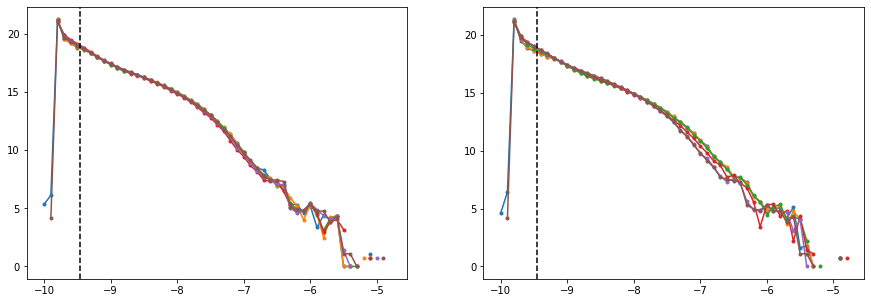

In [764]:
bins=np.arange(-21, 0.1, 0.1)

plt.figure(figsize=(15, 5))


ax = plt.subplot(1, 2, 1)
for lamb in lambs:
    ps_mat = np.load(get_filename('ps_mat', lamb, 0))
    if np.abs(np.sum(ps_mat.dot(lengths_mat))-1)<0.05:
        d = np.digitize(np.log10(ps_mat), bins)
        ps_hist = [np.sum(lengths_mat[d==i]) for i in range(len(bins))]
        plt.plot(bins, np.log(ps_hist), marker='.')
    

plt.axvline(np.log10(1/np.sum(lengths_mat)), color='black', linestyle='--')

plt.subplot(1, 2, 2, sharex=ax)
for lamb in lambs:
    ps_pat = np.load(get_filename('ps_pat', lamb, 0))
    if np.abs(np.sum(ps_pat.dot(lengths_pat))-1)<0.05:
        d = np.digitize(np.log10(ps_pat), bins)
        ps_hist = [np.sum(lengths_pat[d==i]) for i in range(len(bins))]
        plt.plot(bins, np.log(ps_hist), marker='.')

plt.axvline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')

plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


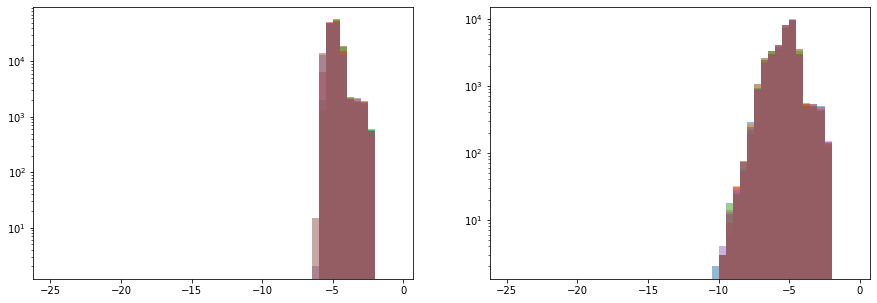

In [765]:
bins=np.arange(-25, 0, 0.5)
plt.figure(figsize=(15, 5))
for i in range(len(lambs)):
    plt.subplot(1, 2, 1)
    ps_mat = np.log10(np.load(get_filename('crossover_ps_mat_train', lambs[i], 0)))
    plt.hist(ps_mat, bins=bins, alpha=0.5, log=True)  
    
    
    plt.subplot(1, 2, 2)
    ps_mat = np.log10(np.load(get_filename('crossover_ps_mat_test', lambs[i], 0)))
    plt.hist(ps_mat, bins=bins, alpha=0.5, log=True)  

plt.show()

In [848]:
co_mat_train, co_mat_test = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
co_pat_train, co_pat_test = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)

co_mat_train_baseline, co_mat_test_baseline = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
co_pat_train_baseline, co_pat_test_baseline = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
   
for i, lamb in enumerate(lambs):
    for k in range(kfolds):
        if exists(get_filename('ps_pat', lamb, k)):
            ps = np.load(get_filename('ps_mat', lamb, k))
            if np.abs(np.sum(ps.dot(lengths_mat))-1)<0.05:
                ps_train = np.load(get_filename('crossover_ps_mat_train', lamb, k))
                ps_test = np.load(get_filename('crossover_ps_mat_test', lamb, k))

                co_mat_train[i, k] = np.sum(np.clip(np.log10(ps_train), -20, None))/len(ps_train)
                co_mat_test[i, k] = np.sum(np.clip(np.log10(ps_test), -20, None))/len(ps_test)

                lengths_train = np.load(get_filename('crossover_lengths_mat_train', lamb, k))
                lengths_test = np.load(get_filename('crossover_lengths_mat_test', lamb, k))
                co_mat_train_baseline[i, k] = np.sum(np.log10(lengths_train/np.sum(lengths_mat)))/len(ps_train)
                co_mat_test_baseline[i, k] = np.sum(np.log10(lengths_test/np.sum(lengths_mat)))/len(ps_test)
            else:
                print('ps dont sum to 1', recomb_dir, lamb, k, np.sum(ps.dot(lengths_mat)))
                    
            ps = np.load(get_filename('ps_pat', lamb, k))
            if np.abs(np.sum(ps.dot(lengths_pat))-1)<0.05:
                ps_train = np.load(get_filename('crossover_ps_pat_train', lamb, k))
                ps_test = np.load(get_filename('crossover_ps_pat_test', lamb, k))

                co_pat_train[i, k] = np.sum(np.clip(np.log10(ps_train), -20, None))/len(ps_train)
                co_pat_test[i, k] = np.sum(np.clip(np.log10(ps_test), -20, None))/len(ps_test)

                lengths_train = np.load(get_filename('crossover_lengths_pat_train', lamb, k))
                lengths_test = np.load(get_filename('crossover_lengths_pat_test', lamb, k))
                co_pat_train_baseline[i, k] = np.sum(np.log10(lengths_train/np.sum(lengths_pat)))/len(ps_train)
                co_pat_test_baseline[i, k] = np.sum(np.log10(lengths_test/np.sum(lengths_pat)))/len(ps_test)
            else:
                print('ps dont sum to 1', recomb_dir, lamb, k, np.sum(ps.dot(lengths_pat)))



In [849]:
print(co_pat_test)

[[-5.19123253 -5.21592527 -5.21819779 -5.20952503 -5.21128437]
 [-5.20890209 -5.18718675 -5.20583306 -5.20144177 -5.19142604]
 [-5.17796871 -5.16549504 -5.16965954 -5.19273862 -5.18091009]
 [-5.17722959 -5.18322083 -5.17494607 -5.17869549 -5.17082424]
 [-5.16998021 -5.20236305 -5.18198147 -5.19985903 -5.18310629]
 [-5.20307779 -5.19661378 -5.18433995         nan         nan]]


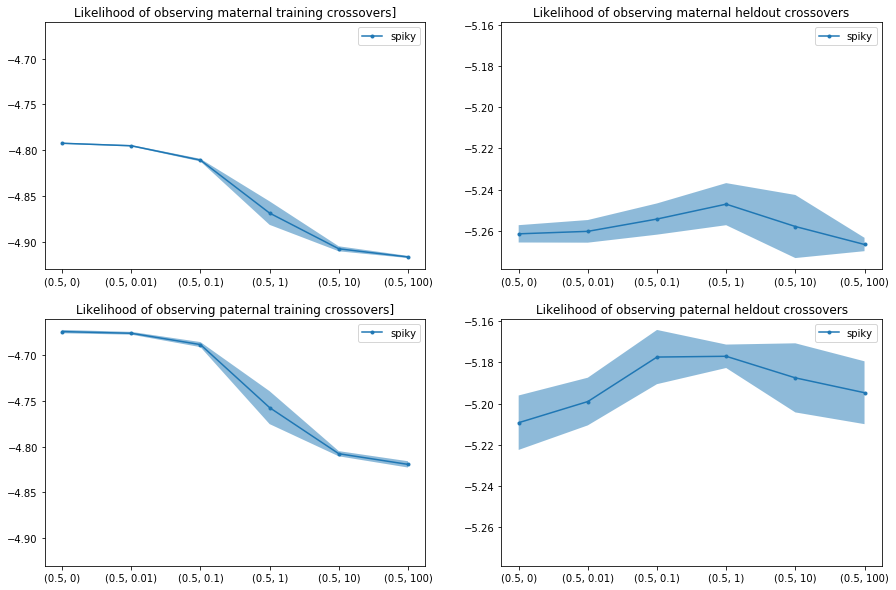

In [850]:
def plot_with_confidence(data, label):
    #print(np.nanmean(data, axis=1))
    plt.plot(range(len(lambs)), np.nanmean(data, axis=1), label=label, marker='.')
    lower, upper = stats.t.interval(0.95, data.shape[1]-1, loc=np.nanmean(data, axis=1), scale=stats.sem(data, axis=1, nan_policy='omit')) # from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    plt.fill_between(range(len(lambs)), lower, upper, alpha=0.5)


plt.figure(figsize=(15, 10))

ax = plt.subplot(2, 2, 1)
#plot_with_confidence(co_mat_train_baseline, 'baseline')
plot_with_confidence(co_mat_train, 'spiky')
plt.title('Likelihood of observing maternal training crossovers]')
plt.xticks(range(len(lambs)), lambs)
plt.legend()

plt.subplot(2, 2, 3, sharey=ax)
#plot_with_confidence(co_pat_train_baseline, 'baseline')
plot_with_confidence(co_pat_train, 'spiky')
plt.title('Likelihood of observing paternal training crossovers]')
plt.xticks(range(len(lambs)), lambs)
plt.legend()

ax = plt.subplot(2, 2, 2)
#plot_with_confidence(co_mat_test_baseline, 'baseline')
plot_with_confidence(co_mat_test, 'spiky')
plt.title('Likelihood of observing maternal heldout crossovers')
plt.xticks(range(len(lambs)), lambs)
plt.legend()

plt.subplot(2, 2, 4, sharey=ax)
#plot_with_confidence(co_pat_test_baseline, 'baseline')
plot_with_confidence(co_pat_test, 'spiky')
plt.title('Likelihood of observing paternal heldout crossovers')
plt.xticks(range(len(lambs)), lambs)
plt.legend()

#plt.tight_layout()
plt.show()

# Look at best performer

In [820]:
lamb = (0.5, 1)
ps_mat = np.load(get_filename('ps_mat', lamb, 0))
ps_pat = np.load(get_filename('ps_pat', lamb, 0))



//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


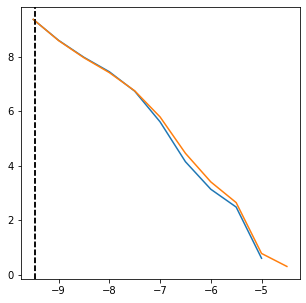

In [821]:
bins=np.arange(-21, 0.01, 0.5)
plt.figure(figsize=(5, 5))
    
d = np.digitize(np.log10(ps_mat), bins)
ps_hist = [np.sum(lengths_mat[d==i]) for i in range(len(bins))]
plt.plot(bins, np.log10(ps_hist))
plt.axvline(np.log10(1/np.sum(lengths_mat)), color='black', linestyle='--')
 
d = np.digitize(np.log10(ps_pat), bins)
ps_hist = [np.sum(lengths_pat[d==i]) for i in range(len(bins))]
plt.plot(bins, np.log10(ps_hist))
plt.axvline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')

plt.show()

In [822]:
is_hotspot_mat = np.log10(ps_mat) > np.log10(1/np.sum(lengths_mat))
is_hotspot_pat = np.log10(ps_pat) > np.log10(1/np.sum(lengths_pat))

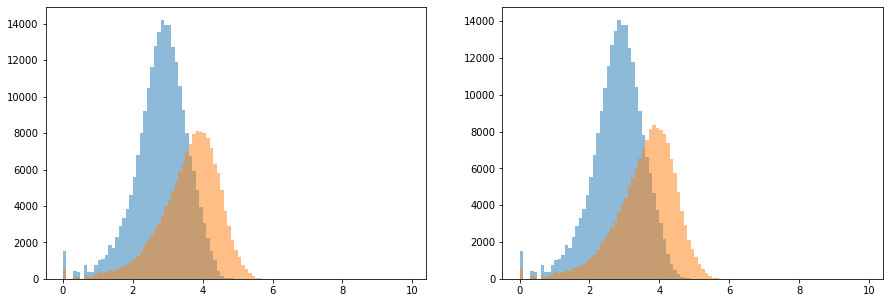

In [823]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(np.log10(lengths_mat[is_hotspot_mat]), alpha=0.5, bins=np.arange(0, 10, 0.1))
plt.hist(np.log10(lengths_mat[~is_hotspot_mat]), alpha=0.5, bins=np.arange(0, 10, 0.1))
plt.subplot(1, 2, 2)
plt.hist(np.log10(lengths_pat[is_hotspot_pat]), alpha=0.5, bins=np.arange(0, 10, 0.1))
plt.hist(np.log10(lengths_pat[~is_hotspot_pat]), alpha=0.5, bins=np.arange(0, 10, 0.1))
plt.show()

In [824]:
print(np.median(lengths_mat[is_hotspot_mat]), np.median(lengths_pat[is_hotspot_pat]))

732.0 724.0


In [825]:
indices = np.where(is_hotspot_mat[1:] != is_hotspot_mat[:-1])[0].tolist() + [len(ps_mat)-1]
#indices = np.where(np.abs(np.log10(ps_mat[1:])-np.log10(ps_mat[:-1]) > 2))[0].tolist() + [len(ps_mat)-1]
interval_lengths_mat, interval_ps_mat = [], []
interval_mapping_mat = []
    
last_index = 0
for i in indices:
    #print(ps_mat[last_index], ps_mat[i])
    #assert np.isclose(ps_mat[last_index], ps_mat[i])
    index = len(interval_lengths_mat)
    l = np.sum(lengths_mat[last_index:(i+1)])
    interval_lengths_mat.append(l)
    interval_ps_mat.append(ps_mat[last_index:(i+1)].dot(lengths_mat[last_index:(i+1)])/l)
    interval_mapping_mat.extend([index]*(i+1-last_index))
    last_index = i+1

    
interval_lengths_mat = np.array(interval_lengths_mat)
interval_ps_mat = np.array(interval_ps_mat)
interval_mapping_mat = np.array(interval_mapping_mat)
print(len(interval_mapping_mat), len(lengths_mat))
assert len(interval_mapping_mat) == len(lengths_mat)

indices = np.where(is_hotspot_pat[1:] != is_hotspot_pat[:-1])[0].tolist() + [len(ps_pat)-1]
#indices = np.where(np.abs(np.log10(ps_pat[1:])-np.log10(ps_pat[:-1]) > 2))[0].tolist() + [len(ps_pat)-1]
interval_lengths_pat, interval_ps_pat = [], []
interval_mapping_pat = []
    
last_index = 0
for i in indices:
    #print(ps_mat[last_index], ps_mat[i])
    #assert np.isclose(ps_mat[last_index], ps_mat[i])
    index = len(interval_lengths_pat)
    l = np.sum(lengths_pat[last_index:(i+1)])
    interval_lengths_pat.append(l)
    interval_ps_pat.append(ps_pat[last_index:(i+1)].dot(lengths_pat[last_index:(i+1)])/l)
    interval_mapping_pat.extend([index]*(i+1-last_index))
    last_index = i+1
    
interval_lengths_pat = np.array(interval_lengths_pat)
interval_ps_pat = np.array(interval_ps_pat)
interval_mapping_pat = np.array(interval_mapping_pat)
assert len(interval_mapping_pat) == len(lengths_pat)

print(len(interval_lengths_mat), len(interval_lengths_pat))

380099 380099
126045 125457


In [826]:
interval_is_hot_mat = np.log10(interval_ps_mat)>np.log10(1/np.sum(lengths_mat))
interval_is_hot_pat = np.log10(interval_ps_pat)>np.log10(1/np.sum(lengths_pat))

print(np.sum(interval_is_hot_mat), np.sum(interval_is_hot_pat))

63022 62728


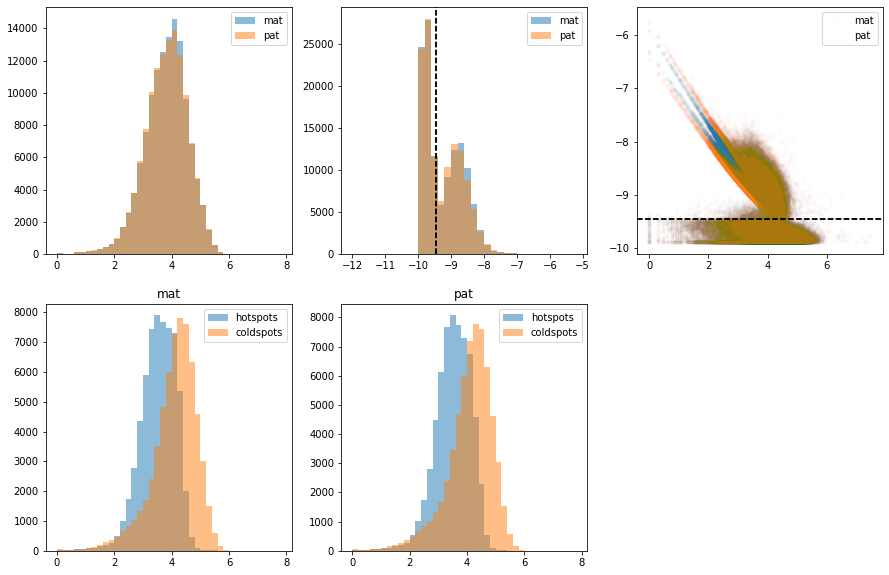

In [827]:
# look at intervals

bins=np.arange(-25, 0, 0.5)
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(np.log10(interval_lengths_mat), bins=np.arange(0, 8, 0.2), alpha=0.5, label='mat')
plt.hist(np.log10(interval_lengths_pat), bins=np.arange(0, 8, 0.2), alpha=0.5, label='pat')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(np.log10(interval_ps_mat), bins=np.arange(-12, -5, 0.2), alpha=0.5, label='mat')
plt.axvline(np.log10(1/np.sum(lengths_mat)), color='black', linestyle='--')
plt.hist(np.log10(interval_ps_pat), bins=np.arange(-12, -5, 0.2), alpha=0.5, label='pat')
plt.axvline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')
plt.legend()

plt.subplot(2, 3, 3)
plt.scatter(np.log10(interval_lengths_mat), np.log10(interval_ps_mat), alpha=0.01, marker='.', label='mat')
plt.axhline(np.log10(1/np.sum(lengths_mat)), color='black', linestyle='--')
plt.scatter(np.log10(interval_lengths_pat), np.log10(interval_ps_pat), alpha=0.01, marker='.', label='pat')
plt.axhline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')
plt.legend()

plt.subplot(2, 3, 4)
#plt.title('hotspots')
plt.title('mat')
plt.hist(np.log10(interval_lengths_mat[interval_is_hot_mat]), 
         bins=np.arange(0, 8, 0.2), alpha=0.5, label='hotspots')
plt.hist(np.log10(interval_lengths_mat[~interval_is_hot_mat]), 
         bins=np.arange(0, 8, 0.2), alpha=0.5, label='coldspots')
#plt.axvline(np.log10(1500), color='black', linestyle='--')
#plt.axvline(np.log10(2000), color='black', linestyle='--')

plt.legend()

plt.subplot(2, 3, 5)
plt.title('pat')

plt.hist(np.log10(interval_lengths_pat[interval_is_hot_pat]), 
         bins=np.arange(0, 8, 0.2), alpha=0.5, label='hotspots')
plt.hist(np.log10(interval_lengths_pat[~interval_is_hot_pat]), 
         bins=np.arange(0, 8, 0.2), alpha=0.5, label='coldspots')
#plt.axvline(np.log10(1500), color='black', linestyle='--')
#plt.axvline(np.log10(2000), color='black', linestyle='--')
plt.legend()


plt.show()

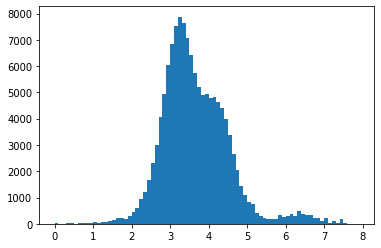

In [828]:
plt.hist(np.log10(cross_lengths_train), bins=np.arange(0, 8, 0.1))
plt.show()

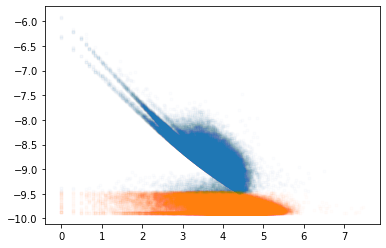

In [829]:
plt.scatter(np.log10(interval_lengths_mat[interval_is_hot_mat]), np.log10(interval_ps_mat[interval_is_hot_mat]),
           marker='.', alpha=0.01)
plt.scatter(np.log10(interval_lengths_mat[~interval_is_hot_mat]), np.log10(interval_ps_mat[~interval_is_hot_mat]),
           marker='.', alpha=0.01)
plt.show()

In [830]:
print(np.median(interval_lengths_mat[interval_is_hot_mat]),
      np.median(interval_lengths_mat[~interval_is_hot_mat]))
print(np.median(interval_lengths_pat[interval_is_hot_pat]),
      np.median(interval_lengths_pat[~interval_is_hot_pat]))

3739.0 15989.0
3538.5 16138.0


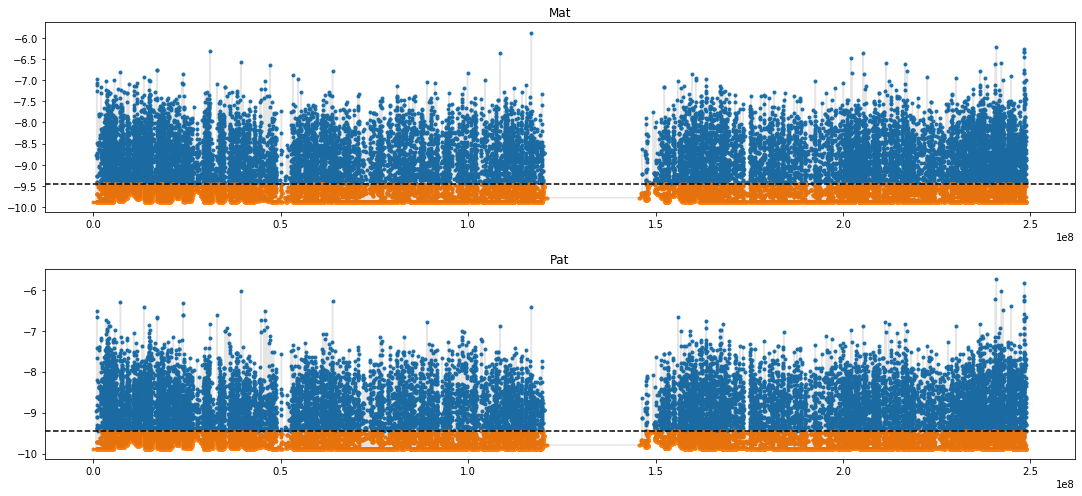

In [831]:
chrom = '1'
plt.figure(figsize=(15, 7))

ax = plt.subplot(2, 1, 1)
plt.title('Mat')
indices = [c==chrom for c in chroms_mat]
p = plt.plot(np.repeat(start_pos_mat[indices], 2)[1:], 
                     np.repeat((np.log10(ps_mat[indices])), 2)[:-1], alpha=0.1, color='black')
plt.scatter(start_pos_mat[indices & is_hotspot_mat],
                    np.log10(ps_mat[indices & is_hotspot_mat]), marker='.')
plt.scatter(start_pos_mat[indices & ~is_hotspot_mat],
                    np.log10(ps_mat[indices & ~is_hotspot_mat]), marker='.')

#for i in range(3):
#    plt.scatter(start_pos_mat[indices & np.isin(interval_mapping_mat, np.where(clustering_mat.labels_==i)[0])],
#                np.log10(ps_mat[indices & np.isin(interval_mapping_mat, np.where(clustering_mat.labels_==i)[0])]), marker='.')
plt.axhline(np.log10(1/np.sum(lengths_mat)), color='black', linestyle='--')
#plt.xlim([10000000, 11000000])
        
plt.subplot(2, 1, 2, sharex=ax)
plt.title('Pat')
indices = [c==chrom for c in chroms_pat]
q = plt.plot(np.repeat(start_pos_pat[indices], 2)[1:], 
                 np.repeat((np.log10(ps_pat[indices])), 2)[:-1], alpha=0.1, color='black')
plt.scatter(start_pos_pat[indices & is_hotspot_pat],
                    np.log10(ps_pat[indices & is_hotspot_pat]), marker='.')
plt.scatter(start_pos_pat[indices & ~is_hotspot_pat],
                    np.log10(ps_pat[indices & ~is_hotspot_pat]), marker='.')
#for i in range(3):
#    plt.scatter(start_pos_pat[indices & np.isin(interval_mapping_pat, np.where(clustering_pat.labels_==i)[0])],
#                np.log10(ps_pat[indices & np.isin(interval_mapping_pat, np.where(clustering_pat.labels_==i)[0])]), marker='.')

plt.axhline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')
#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)
#plt.xlim([0, 10000000])
#plt.ylim([-12, -8])

plt.tight_layout()
plt.show()


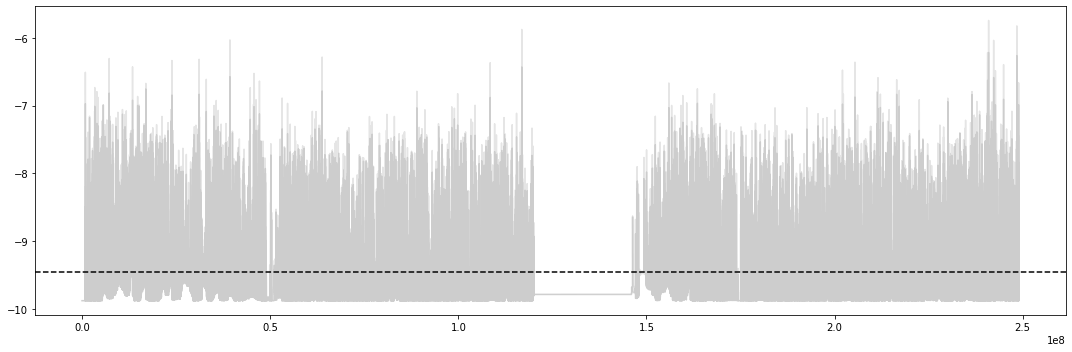

In [836]:
chrom = '1'
plt.figure(figsize=(15, 5))

indices = np.array([c==chrom for c in chroms_mat])
p = plt.plot(np.repeat(start_pos_mat[indices], 2)[1:], 
                     np.repeat((np.log10(ps_mat[indices])), 2)[:-1], alpha=0.1, color='black')

indices = indices & (np.abs(np.log10(ps_mat)-np.log10(ps_pat))>1)
plt.scatter(start_pos_mat[indices], np.log10(ps_mat[indices]), marker='.')

indices = [c==chrom for c in chroms_pat]
q = plt.plot(np.repeat(start_pos_pat[indices], 2)[1:], 
                 np.repeat((np.log10(ps_pat[indices])), 2)[:-1], alpha=0.1, color='black')

indices = indices & (np.abs(np.log10(ps_mat)-np.log10(ps_pat))>1)
plt.scatter(start_pos_pat[indices], np.log10(ps_pat[indices]), marker='.')

plt.axhline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')
#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)
#plt.xlim([4000000, 5000000])
#plt.ylim([-12, -8])

plt.tight_layout()
plt.show()


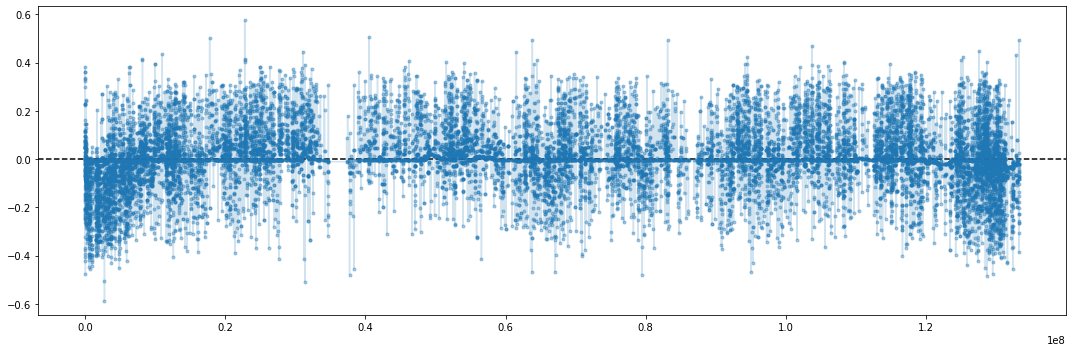

In [847]:
chrom = '12'
plt.figure(figsize=(15, 5))

plt.axhline(0, color='black', linestyle='--')
indices = np.array([c==chrom for c in chroms_mat])
p = plt.plot(np.repeat(start_pos_mat[indices], 2)[1:], 
                     np.repeat((np.log10(ps_mat[indices])-np.log10(ps_pat[indices])), 2)[:-1], 
             alpha=0.2, marker='.')


#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)
#plt.xlim([4000000, 5000000])
#plt.ylim([-12, -8])

plt.tight_layout()
plt.show()


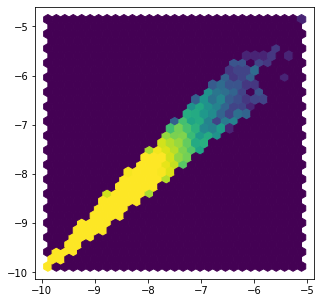

In [838]:
plt.figure(figsize=(5, 5))
plt.hexbin(np.log10(ps_mat), np.log10(ps_pat), gridsize=30, bins='log', vmax=10**3)
plt.show()

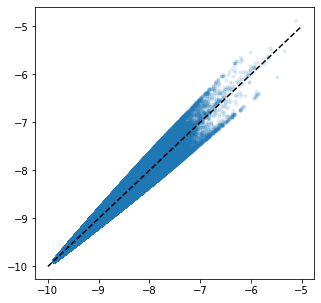

In [839]:
plt.figure(figsize=(5, 5))
plt.scatter(np.log10(ps_mat), np.log10(ps_pat), marker='.', alpha=0.1)
plt.plot([-10, -5], [-10, -5], color='black', linestyle='--')
plt.show()